In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, save_model
from keras.layers import LSTM, GRU
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import string
import re

# Exploring the training data

In [2]:
df_train = pd.read_csv('Data/train.csv')

In [3]:
# Removing columns that are only available in training data (not accessable for test data or real world data)
columns_to_remove = ['shutdown', 'mini_shutdown', 'blackout', 'frankfurt_shutdown', 'precipitation', 'mov_change', 'snow', 'user_activity_1', 'user_activity_2', 'id' ]

df_train.drop(columns_to_remove, axis=1, inplace=True)


In [4]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
orders,7340.0,5535.443869,2182.680279,790.0,4434.0,5370.0,7009.25,18139.0
holiday,7340.0,0.027248,0.162816,0.0,0.0,0.0,0.00,1.0
shops_closed,7340.0,0.010899,0.103836,0.0,0.0,0.0,0.00,1.0
winter_school_holidays,7340.0,0.029973,0.170524,0.0,0.0,0.0,0.00,1.0
school_holidays,7340.0,0.007084,0.083876,0.0,0.0,0.0,0.00,1.0


In [5]:
# Checking for nulls
df_train.isnull().sum()

warehouse                    0
date                         0
orders                       0
holiday_name              7122
holiday                      0
shops_closed                 0
winter_school_holidays       0
school_holidays              0
dtype: int64

In [6]:
# Checking for numbers of samples for each warehouse
df_train['warehouse'].value_counts()

Prague_1       1193
Brno_1         1193
Prague_2       1193
Prague_3       1193
Budapest_1     1154
Munich_1        785
Frankfurt_1     629
Name: warehouse, dtype: int64

In [7]:
# Checking unique holidays and their frequencies in the dataset
df_train['holiday_name'].value_counts()

International womens day                                       26
Christmas Eve                                                  23
New Years Day                                                  16
2nd Christmas Day                                              16
Cyrila a Metodej                                               12
Den vzniku samostatneho ceskoslovenskeho statu                 12
Den ceske statnosti                                            12
Jan Hus                                                        12
Den boje za svobodu a demokracii                               12
Den osvobozeni                                                 12
Labour Day                                                     12
Easter Monday                                                  12
Good Friday                                                    12
Memorial Day of the Republic                                    4
Memorial Day for the Victims of the Communist Dictatorships     4
Memorial D

In [8]:
# Convert to datetime type for further processing and plotting
df_train['date']= pd.to_datetime(df_train['date'])

# Visualizing the data

<function matplotlib.pyplot.show(close=None, block=None)>

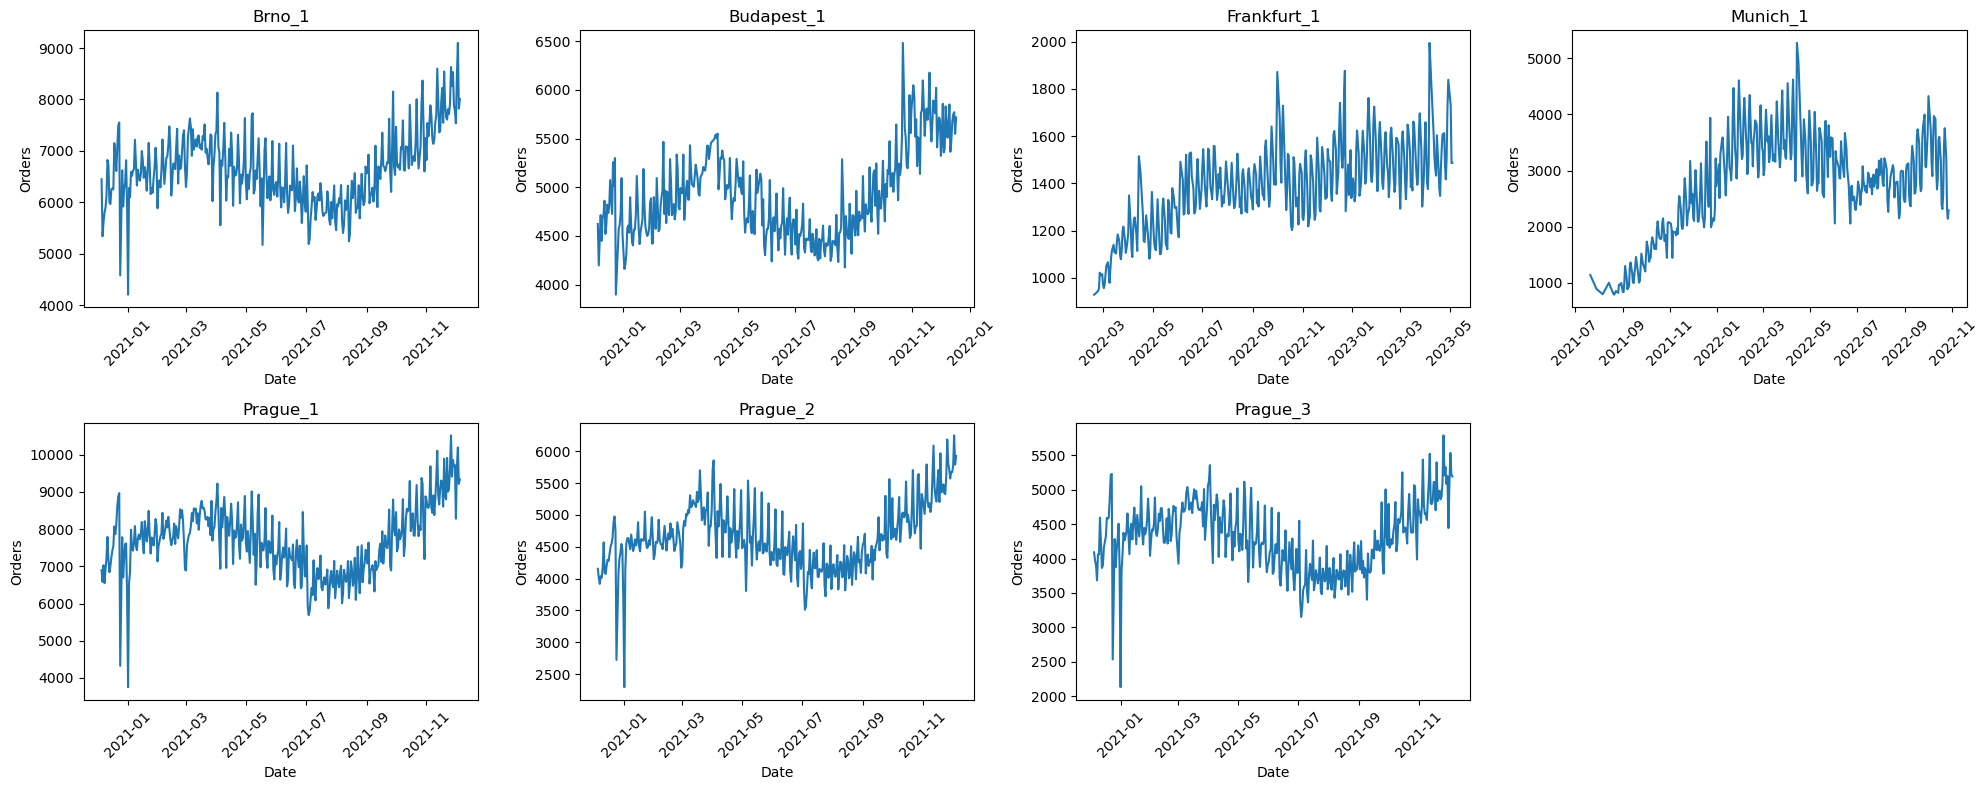

In [9]:
# Visualize the orders time series grouped by each individual warehouse to check for trends and seasonality across different warehouses
dfs_by_warehouse = {warehouse: warehouse_df for warehouse, warehouse_df in df_train.groupby('warehouse')}

plt.figure(figsize=(20, 8))
for i, warehouse in enumerate(dfs_by_warehouse.keys()):
    plt.subplot(2,4,i+1)
    plt.title(warehouse)
    current_warehouse = dfs_by_warehouse[warehouse]
    x = current_warehouse['date'].head(365)
    y = current_warehouse['orders'].head(365)
    plt.plot(x, y)
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

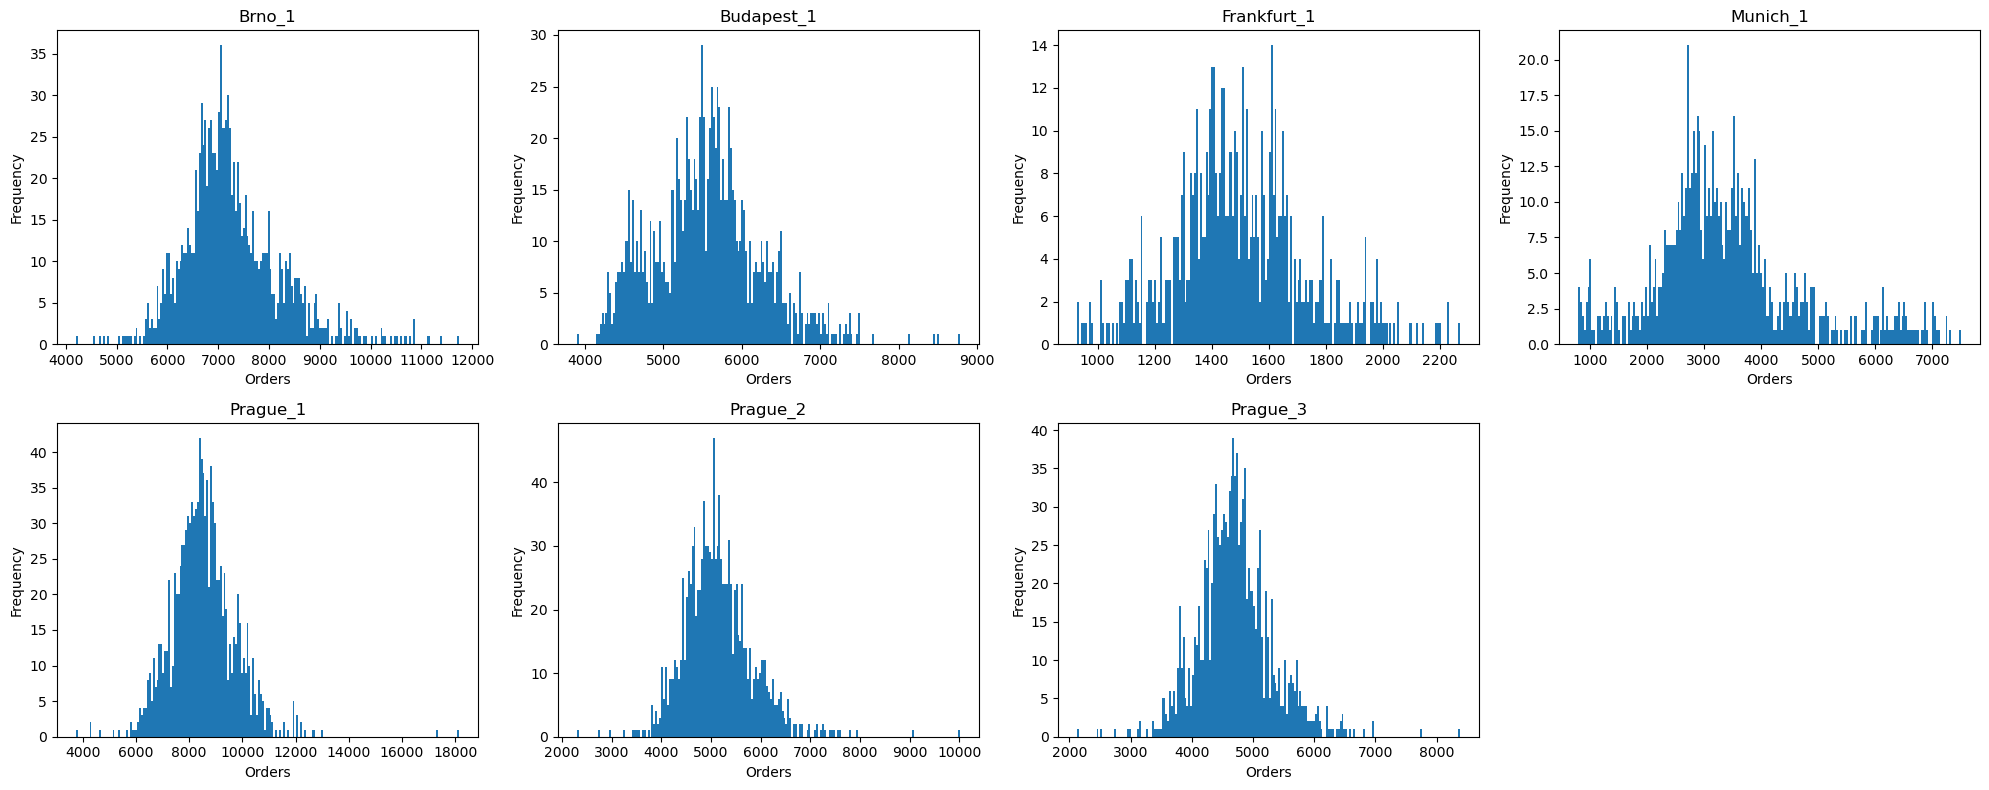

In [10]:
# Checking the distribution of the data
plt.figure(figsize=(20, 8))
for i, warehouse in enumerate(dfs_by_warehouse.keys()):
    plt.subplot(2,4,i+1)
    plt.title(warehouse)
    current_warehouse = dfs_by_warehouse[warehouse]
    x = current_warehouse['orders']
    plt.hist(x, bins = 200)
    plt.xlabel('Orders')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show

# Splitting the data into train/dev sets

In [11]:
# Takes the last N days (for each warehouse) for the validation set and the rest for training set
def split_train_dev(df, dev_set_size=0.2):
    train_dfs = []
    dev_dfs = []
    
    for warehouse, warehouse_df in df.groupby('warehouse'):
        # Calculate the number of days to include in the dev set based on the percentage
        n_days = int(len(warehouse_df) * dev_set_size)

        # Get the last N days for the dev set
        dev_df = warehouse_df.tail(n_days)
        
        # Get the rest of the data for the train set
        train_df = warehouse_df.iloc[:-n_days]
        
        # Append to lists
        train_dfs.append(train_df)
        dev_dfs.append(dev_df)
    
    # Concatenate the individual warehouse train/dev DataFrames
    train_set = pd.concat(train_dfs).reset_index(drop=True)
    dev_set = pd.concat(dev_dfs).reset_index(drop=True)
    
    return train_set, dev_set


In [12]:
# Split the data
train_set, dev_set = split_train_dev(df_train, dev_set_size = 0.2)

# Display the shape of each set
print(f"Train set shape: {train_set.shape}")
print(f"Dev set shape: {dev_set.shape}")


Train set shape: (5876, 8)
Dev set shape: (1464, 8)


# Preprocessing

In [13]:
# Filling null holidays with 'None'
train_set['holiday_name'].fillna('None', inplace=True)
dev_set['holiday_name'].fillna('None', inplace=True)

In [14]:
# Function to onehot encode columns
def onehot_encode(df, columns, encoder: OneHotEncoder, is_test = False):
    # Perform one-hot encoding on the specified columns, and fit the encoder if training
    if is_test:
        encoded = encoder.transform(df[columns])
    else:     
        encoded = encoder.fit_transform(df[columns])
    # Convert it to a DataFrame with appropriate column names
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(columns))
    # Concatenate with the original DataFrame
    df = pd.concat([df, encoded_df], axis=1)
    
    return df

In [15]:
# Perform onehot encoding for warehouse column on train and dev sets
columns_to_encode = ['warehouse', 'holiday_name']

onehot_encoder = OneHotEncoder(sparse_output= False, handle_unknown= 'ignore')

train_set = onehot_encode(train_set, columns_to_encode, onehot_encoder)
dev_set = onehot_encode(dev_set, columns_to_encode, onehot_encoder, is_test= True)

In [16]:
# Check out the result of one hot encoding
warehouse_columns = [col for col in train_set.columns if col.startswith('warehouse')]
warehouse_columns

['warehouse',
 'warehouse_Brno_1',
 'warehouse_Budapest_1',
 'warehouse_Frankfurt_1',
 'warehouse_Munich_1',
 'warehouse_Prague_1',
 'warehouse_Prague_2',
 'warehouse_Prague_3']

In [17]:
train_set[warehouse_columns].sample(2)

,warehouse,warehouse_Brno_1,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3
799,Brno_1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5225,Prague_3,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [18]:

# Extracts meaningful features from date column
def preprocess_dates(df: pd.DataFrame):
    # Ensure the date column is in datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    # Extracting date features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['timestamp_days'] = (df['date'] - pd.Timestamp("1970-01-01")) / pd.Timedelta('1D')    
    df['quarter'] = df['date'].dt.quarter
    df['week_number'] = df['date'].dt.isocalendar().week
    df['day_of_week'] = df['date'].dt.dayofweek
    df['week_of_month'] = df['date'].apply(lambda x: (x.day - 1) // 7 + 1)
    df["is_month_start"] = df['date'].dt.is_month_start.astype(int).fillna(-1)
    df["is_month_end"] = df['date'].dt.is_month_end.astype(int).fillna(-1)
    df["is_quarter_start"] = df['date'].dt.is_quarter_start.astype(int).fillna(-1)
    df["is_quarter_end"] = df['date'].dt.is_quarter_end.astype(int).fillna(-1)
    df['is_weekend'] = np.where(df['day_of_week'].isin([5,6]), 1,0)

    return df

In [19]:
# Preprocess the dates
train_set = preprocess_dates(train_set)
dev_set = preprocess_dates(dev_set)

In [20]:
# Function to scale columns
def scale(df, columns, scaler: StandardScaler, is_test = False):
    # Perform standard scaling on the specified columns, and fit the scaler if training
    if is_test:
        df[columns] = scaler.transform(df[columns])
    else:     
        df[columns] = scaler.fit_transform(df[columns])
    return df

In [21]:
# Apply the scaling for orders and timestamp, but use different scalers for each (to use orders inverse scaler later after predictions)
orders_scaler = StandardScaler()
date_scaler = StandardScaler()

# Date features to scale
date_features = ['year', 'month', 'day', 'timestamp_days', 'quarter', 'week_number','day_of_week', 'week_of_month']

train_set = scale(train_set, ['orders'], orders_scaler)
dev_set = scale(dev_set, ['orders'], orders_scaler, is_test= True)

train_set = scale(train_set, date_features, date_scaler)
dev_set = scale(dev_set, date_features, date_scaler, is_test= True)


In [22]:
# Finally make sure columns are of the same order in both sets
train_set = train_set[sorted(train_set.columns)]
dev_set = dev_set[sorted(dev_set.columns)]

In [23]:
# Display the shape of each set
print(f"Train set shape: {train_set.shape}")
print(f"Dev set shape: {dev_set.shape}")

Train set shape: (5876, 53)
Dev set shape: (1464, 53)


# Training models and evaluation

## Machine learning regression models

In [24]:
# Add lag features (features from the past)
def add_rolling_features(df, lag_columns, window_size=14):
    rolling_dfs = []
    
    # Group by warehouse
    for _, warehouse_df in df.groupby('warehouse'):
        # For each warehouse, create a dictionary to store the lagged features
        lagged_features = {}
        
        # For each column, add lagged features for the past N days
        for col in lag_columns:
            for i in range(1, window_size + 1):
                lagged_features[f'{col}_lag_{i}'] = warehouse_df[col].shift(i)
        
        # Create a DataFrame from the lagged features
        lagged_df = pd.DataFrame(lagged_features)
        
        # Concatenate the original warehouse_df with the lagged features
        warehouse_df = pd.concat([warehouse_df, lagged_df], axis=1)
        
        # Drop rows with missing rolling data (those with insufficient history)
        warehouse_df = warehouse_df.dropna().reset_index(drop=True)
        
        # Append processed dataframe to the list
        rolling_dfs.append(warehouse_df)
    
    return pd.concat(rolling_dfs, axis=0)

In [25]:
window_size = 14

# Get the last N days from each warehouse in the train_set
last_n_days = train_set.groupby('warehouse').tail(window_size)

# Save an unrolled copy of dev set (to take last 14 days for test later)
dev_set_unrolled = dev_set.copy()

# Append the last N days to the dev_set
dev_set = pd.concat([last_n_days, dev_set]).reset_index(drop=True)

# Features to take from the past N days
features_to_roll = ['orders', 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']

# Apply rolling features function to both train_set and extended dev_set
train_set = add_rolling_features(train_set, features_to_roll, window_size)
dev_set = add_rolling_features(dev_set, features_to_roll, window_size)

# Display the shape of each set
print(f"Train set shape: {train_set.shape}")
print(f"Dev set shape: {dev_set.shape}")


Train set shape: (5778, 123)
Dev set shape: (1464, 123)


In [26]:
# Drop the columns we encoded and vectorized earlier as they are not needed now (warehouse and holiday_name)
# But first save the wharehouse columns because they are needed for plotting to group by warehouse
train_warehouse = train_set['warehouse']
dev_warehouse = dev_set['warehouse']

train_set = train_set.drop(columns_to_encode, axis=1)
dev_set = dev_set.drop(columns_to_encode, axis=1,)

In [27]:
# Similarly drop the date column but save it first
train_date = train_set['date']
dev_date = dev_set['date']

train_set = train_set.drop('date', axis=1)
dev_set = dev_set.drop('date', axis=1,)

In [28]:
# Make sure all columns are of type float
train_set = train_set.astype('float32')
dev_set = dev_set.astype('float32')

In [29]:
# Separate data into X and y for train and dev sets
X_train = train_set.drop('orders', axis=1)
y_train = train_set['orders']

X_dev = dev_set.drop('orders', axis=1)
y_dev = dev_set['orders']

In [30]:
# Function to compute metrics given predicted values vs ground truth (actual values)
def calculate_metrics(y_actual, y_pred):
    # Calculate some metrics like R2, MAE and MAPE
    r2 = r2_score(y_actual, y_pred)
    mae = mean_absolute_error(y_actual, y_pred)
    mape = mean_absolute_percentage_error(y_actual, y_pred)

    # Print metrics
    print(f"R2 Score: {r2*100:0.4f}%")
    print(f"MAE: {mae:0.4f}")
    print(f"MAPE: {mape*100:0.4f}%")
    
    return r2, mae, mape

In [31]:
# Plot predictions vs actual values.
def visualize_performance(y_actual, y_pred):
    plt.figure(figsize=(6, 4))
    plt.scatter(y_actual, y_pred, alpha=0.5)
    plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs. Predicted Values')
    plt.grid(True)
    plt.show()

In [32]:
# Plots a graph of the model's predictions on train and dev set across timestamps, grouped by warehouse
def plot_model_forecast(X_train, X_dev, y_train, y_train_pred, y_dev, y_dev_pred, train_date, dev_date, train_warehouse, dev_warehouse):
    # Create copies of X_train and X_dev to avoid modifying the original data
    X_train_copy = X_train.copy()
    X_dev_copy = X_dev.copy()

    # Add the dates and warehouses back to plot them (they were removed earlier in preprocessing)
    X_train_copy['date'] = train_date
    X_train_copy['warehouse'] = train_warehouse
    X_dev_copy['date'] = dev_date
    X_dev_copy['warehouse'] = dev_warehouse

    # Create dataframes for train and dev with actual and predicted orders
    X_train_copy['actual_orders'] = y_train
    X_train_copy['predicted_orders'] = y_train_pred

    X_dev_copy['actual_orders'] = y_dev
    X_dev_copy['predicted_orders'] = y_dev_pred
            
    # Group train and dev data by warehouse
    train_by_warehouse = {warehouse: warehouse_df for warehouse, warehouse_df in X_train_copy.groupby('warehouse')}
    dev_by_warehouse = {warehouse: warehouse_df for warehouse, warehouse_df in X_dev_copy.groupby('warehouse')}

    # Plot predictions and actuals for each warehouse individually
    for warehouse in train_by_warehouse.keys():
        plt.figure(figsize=(14, 5))
        plt.title(f"Warehouse: {warehouse}")
        
        # Get train and dev data for current warehouse
        train_warehouse_data = train_by_warehouse[warehouse].tail(90)
        dev_warehouse_data = dev_by_warehouse.get(warehouse, pd.DataFrame()).head(50)  # Get dev data for the warehouse or empty if none

        # Plot actual orders for train and dev
        plt.plot(train_warehouse_data['date'], train_warehouse_data['actual_orders'], label='Train Actual', color='blue', linestyle='-')
        plt.plot(dev_warehouse_data['date'], dev_warehouse_data['actual_orders'], label='Dev Actual', color='green', linestyle='-')

        # Plot predicted orders for train and dev
        plt.plot(train_warehouse_data['date'], train_warehouse_data['predicted_orders'], label='Train Predicted', color='orange', linestyle='--')
        plt.plot(dev_warehouse_data['date'], dev_warehouse_data['predicted_orders'], label='Dev Predicted', color='red', linestyle='--')

        plt.xlabel('Date')
        plt.ylabel('Orders')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout() 
        plt.show()


In [33]:
# Fit a model on training data and evaluate and visualize on dev data
def train_eval_model(X_train, y_train, X_dev, y_dev, model, scaler: StandardScaler):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the training set
    y_train_pred = model.predict(X_train)

    # Make predictions on the validation set
    y_dev_pred = model.predict(X_dev)
    
    # Make some copies to manipulate
    y_train_copy = y_train.copy()
    y_dev_copy = y_dev.copy()
    
    # Reshape predictions to 2D for inverse scaling (StandardScaler expects 2D arrays)
    y_train_pred = y_train_pred.reshape(-1, 1)
    y_dev_pred = y_dev_pred.reshape(-1, 1)
    
    y_train_copy = np.array(y_train_copy).reshape(-1, 1)
    y_dev_copy= np.array(y_dev_copy).reshape(-1, 1)
    
    # Inverse scale the target variable predictions back to the original scale
    y_train_pred = scaler.inverse_transform(y_train_pred).reshape(-1)
    y_dev_pred = scaler.inverse_transform(y_dev_pred).reshape(-1)

    y_train_copy = scaler.inverse_transform(y_train_copy).reshape(-1)
    y_dev_copy = scaler.inverse_transform(y_dev_copy).reshape(-1)

    # Calculate metrics for training set
    print(f"Metrics on Training Set:")
    calculate_metrics(y_train_copy, y_train_pred)
    
    print("---------------------------------------------")
    
    # Calculate metrics for validation set
    print(f"Metrics on Validation Set:")
    calculate_metrics(y_dev_copy, y_dev_pred)
    
    # Plot some visualizations
    visualize_performance(y_dev_copy, y_dev_pred)
    plot_model_forecast(X_train, X_dev, y_train_copy, y_train_pred, y_dev_copy, y_dev_pred, train_date, dev_date, train_warehouse, dev_warehouse)


### 1. XGBoost

Metrics on Training Set:
R2 Score: 99.4288%
MAE: 112.3226
MAPE: 2.3741%
---------------------------------------------
Metrics on Validation Set:
R2 Score: 94.1588%
MAE: 337.4363
MAPE: 5.3023%


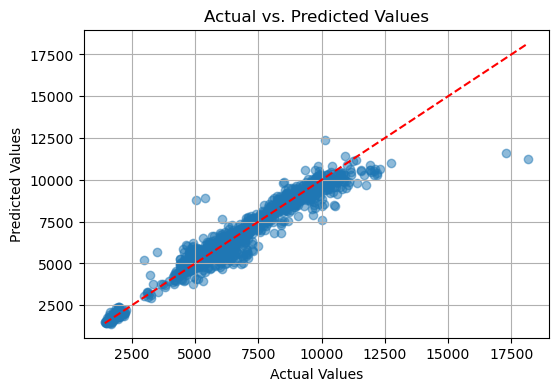

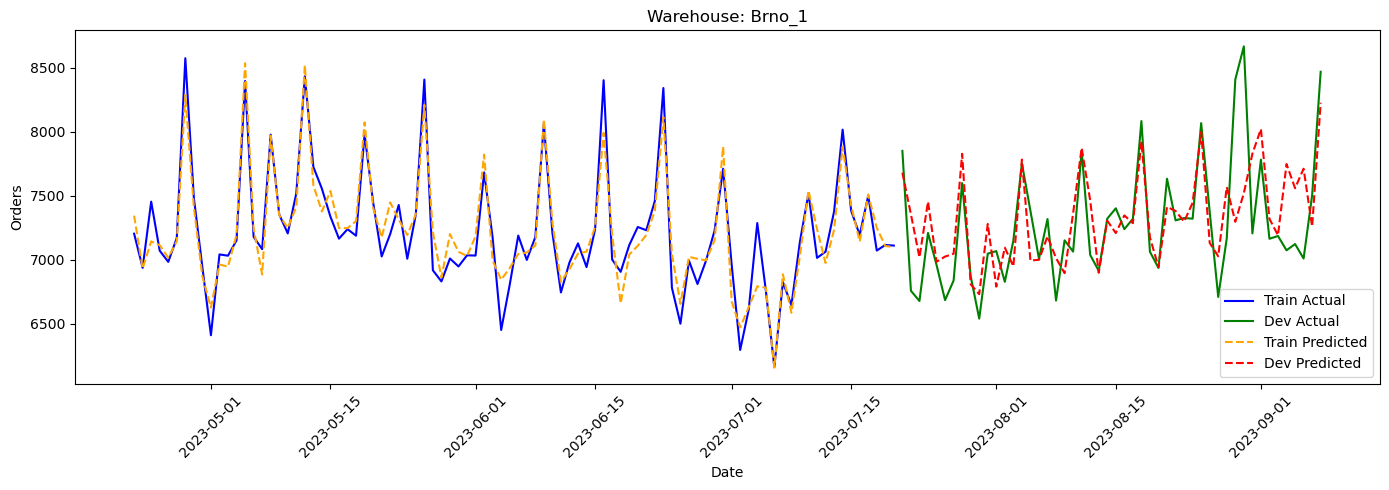

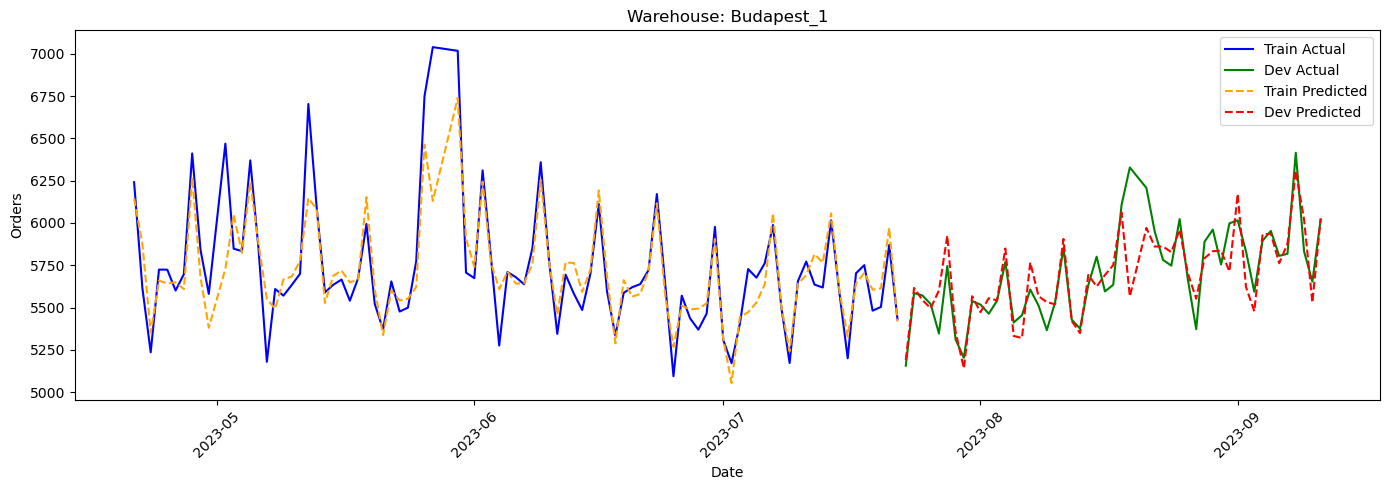

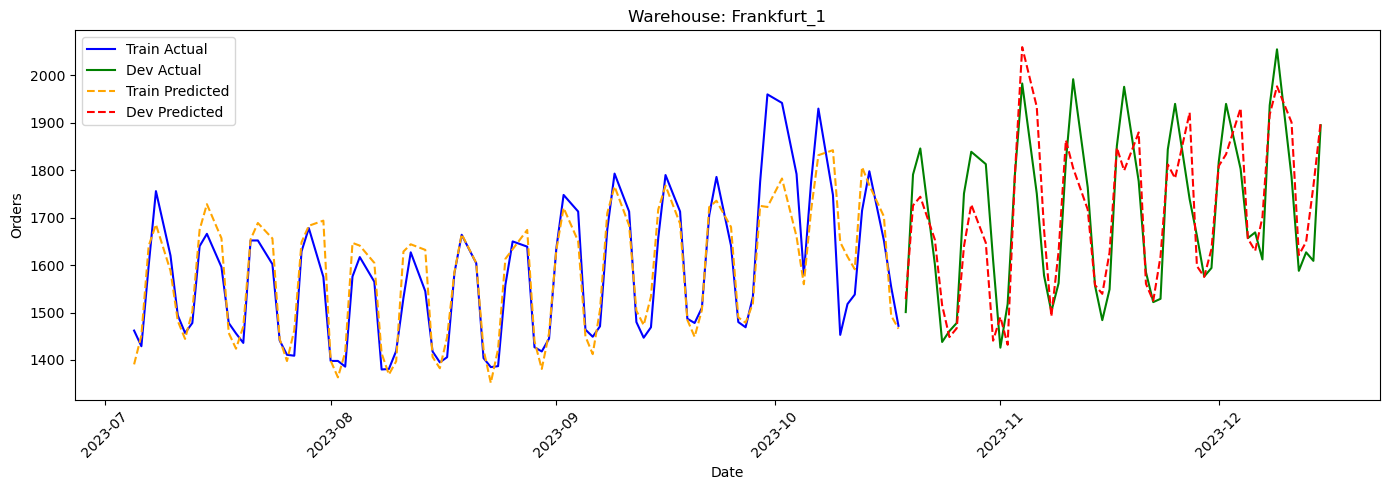

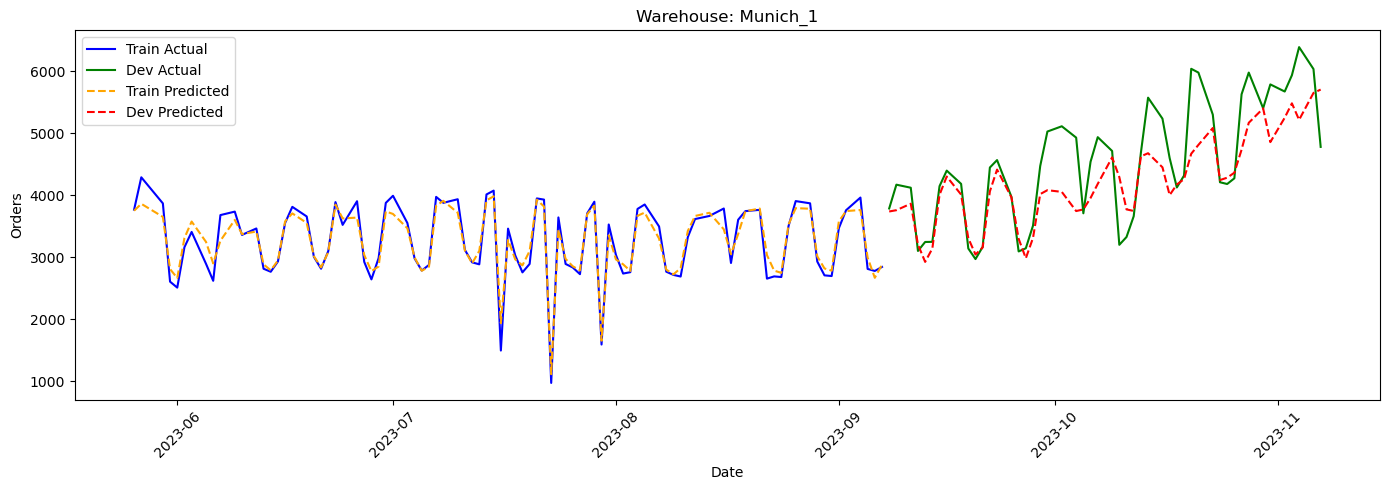

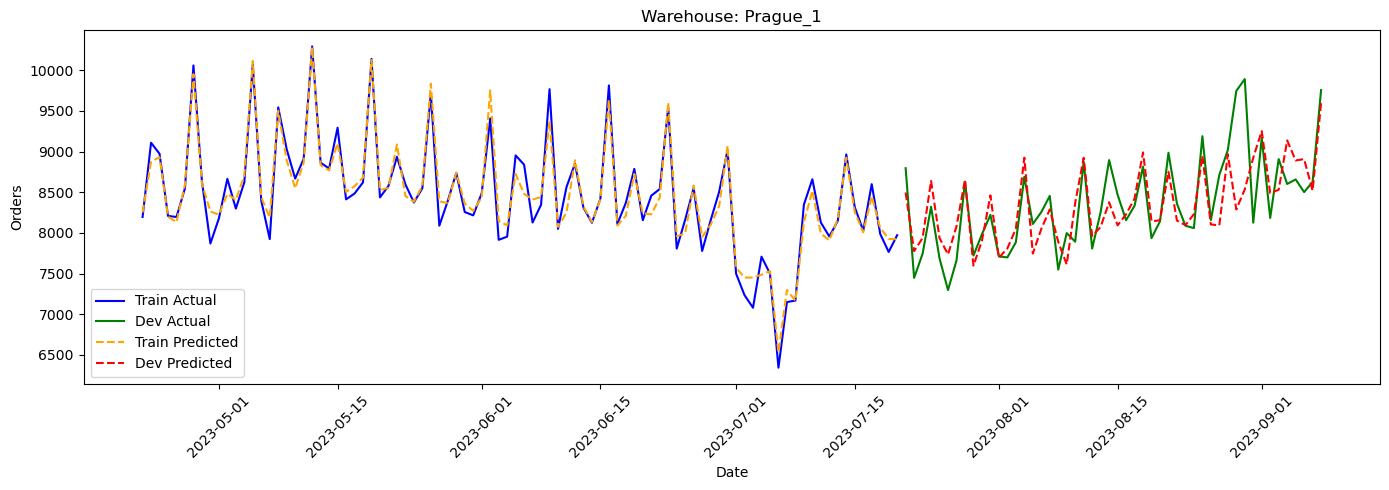

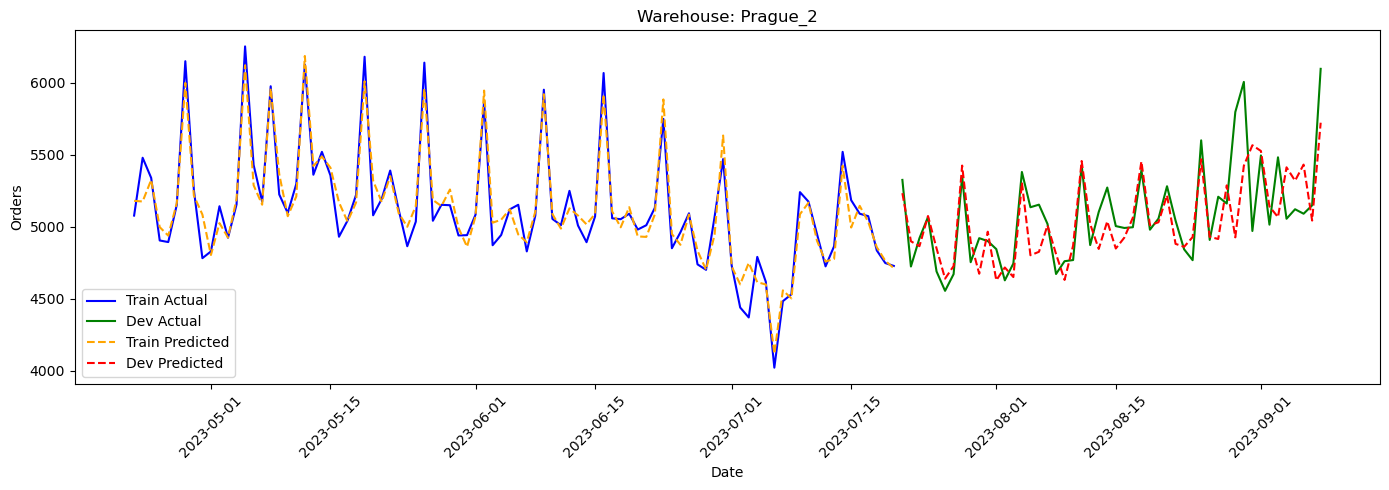

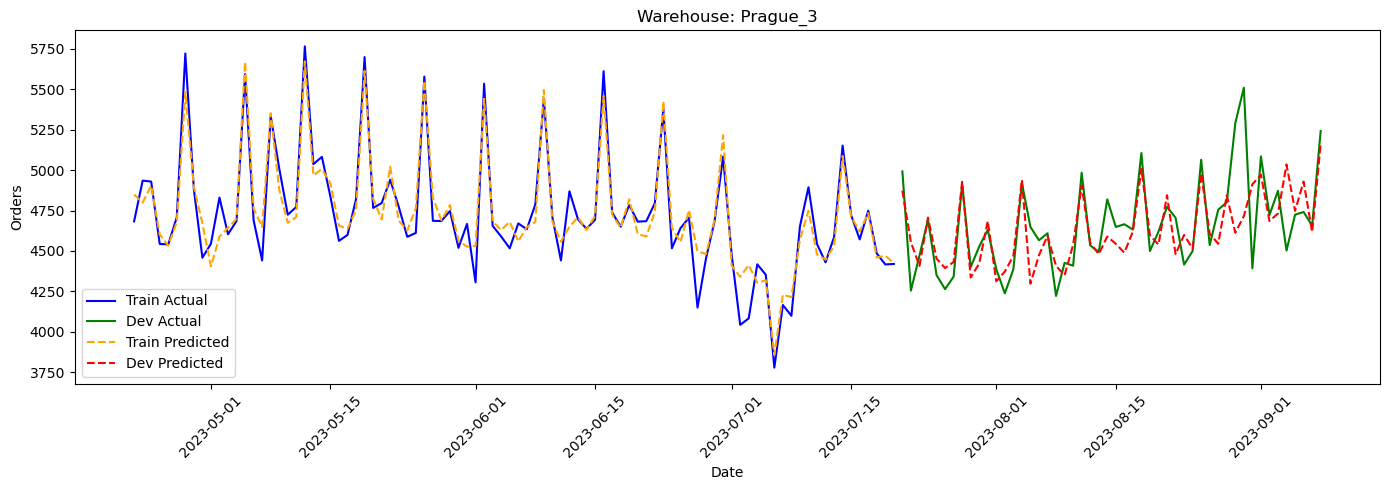

In [34]:
xgb = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=4, random_state=42)
train_eval_model(X_train, y_train, X_dev, y_dev, xgb, orders_scaler)

### 2. CatBoost

Metrics on Training Set:
R2 Score: 99.9557%
MAE: 32.4334
MAPE: 0.7410%
---------------------------------------------
Metrics on Validation Set:
R2 Score: 94.5509%
MAE: 341.5148
MAPE: 5.5336%


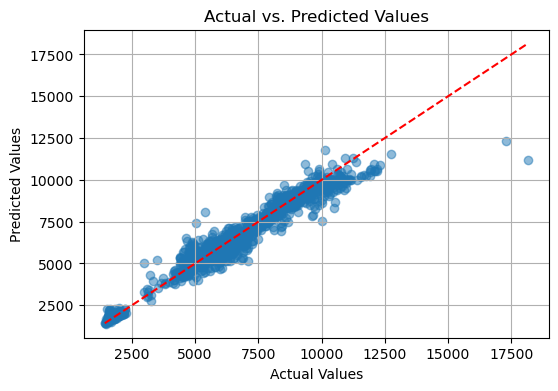

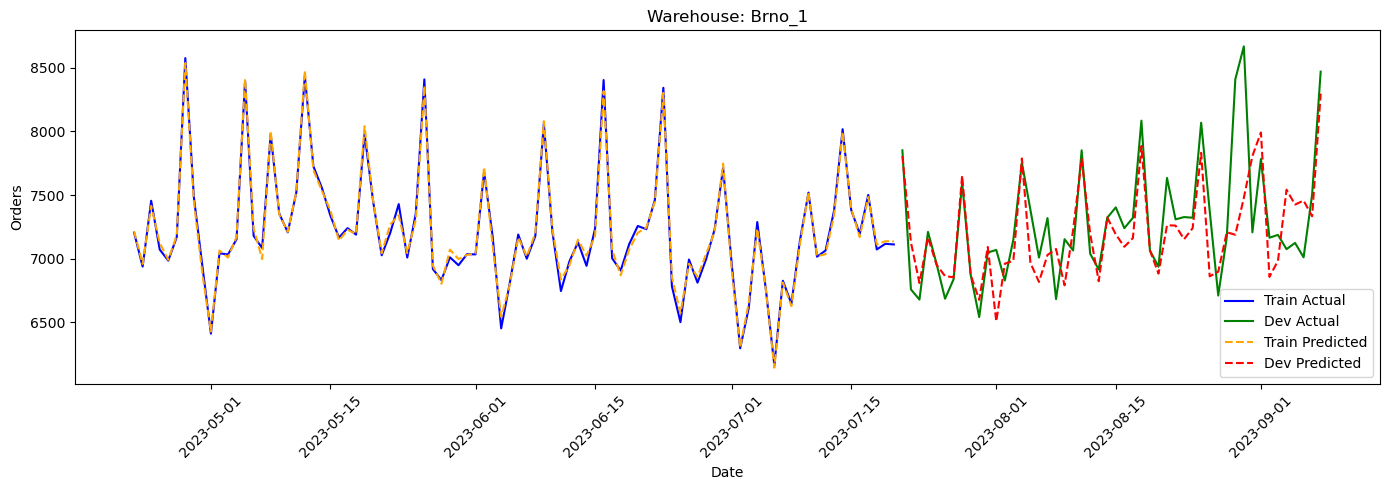

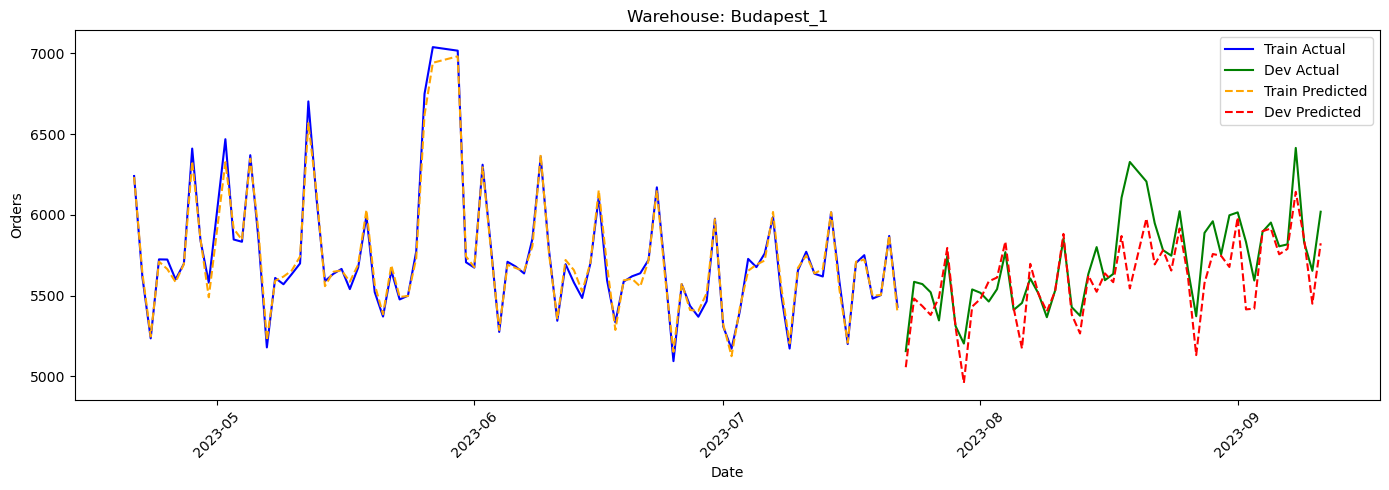

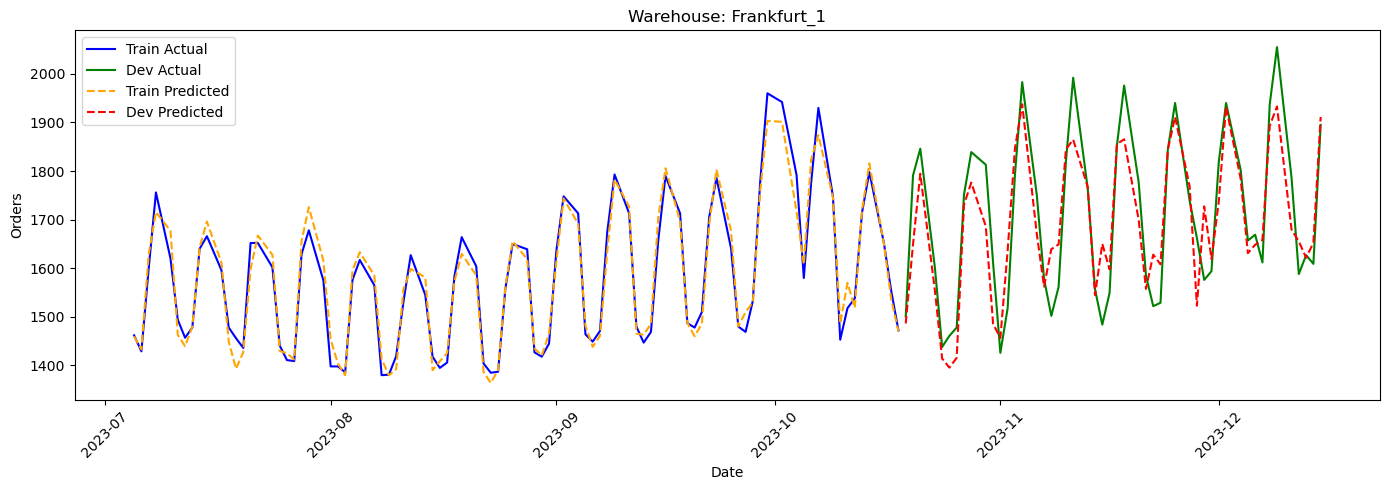

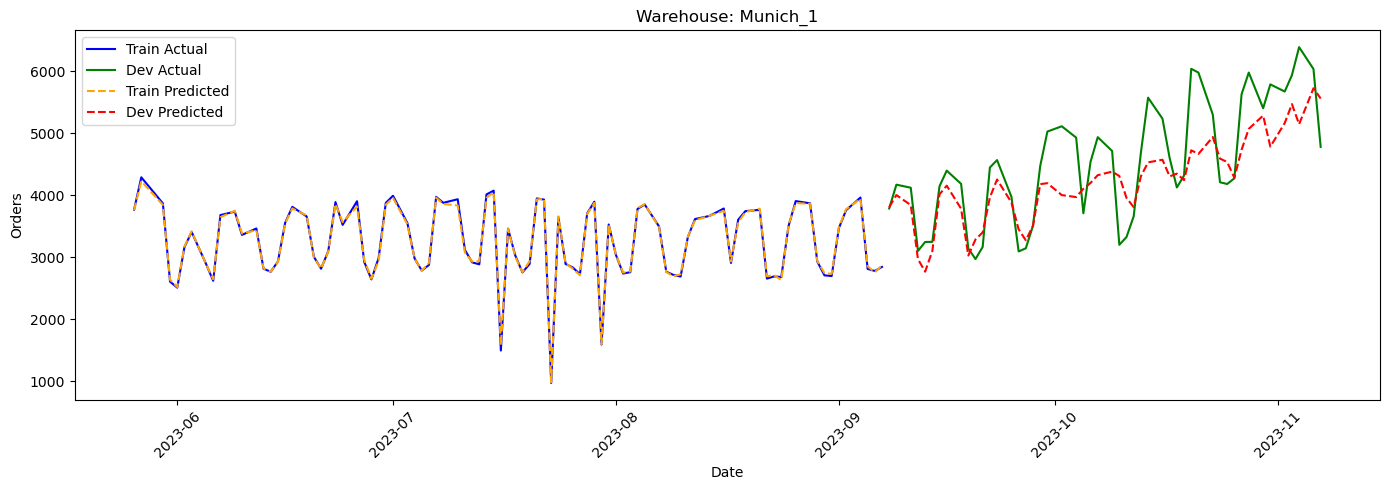

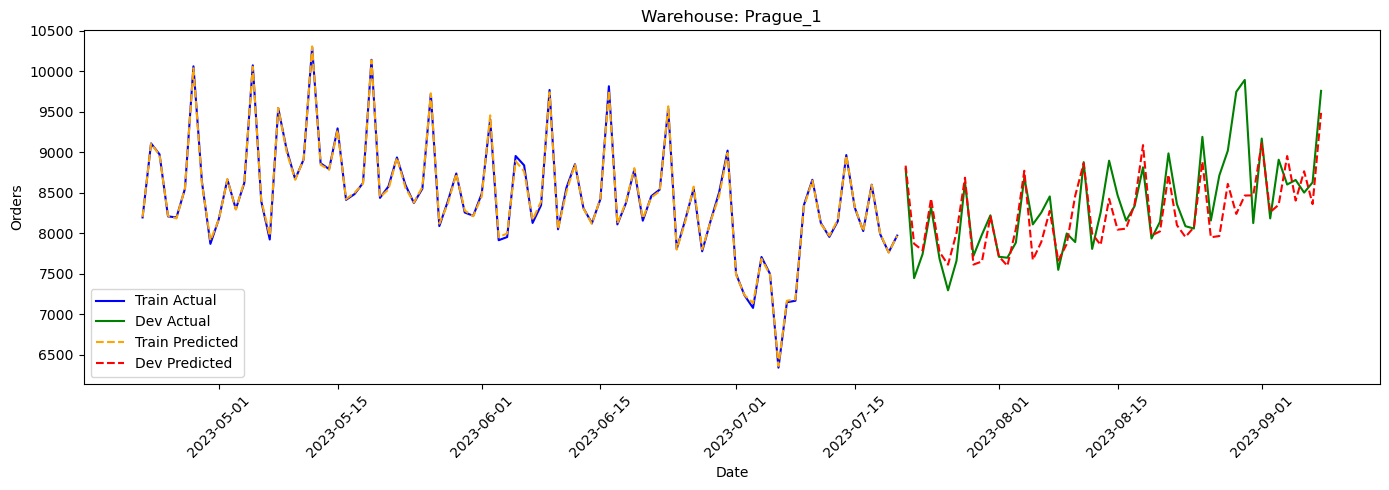

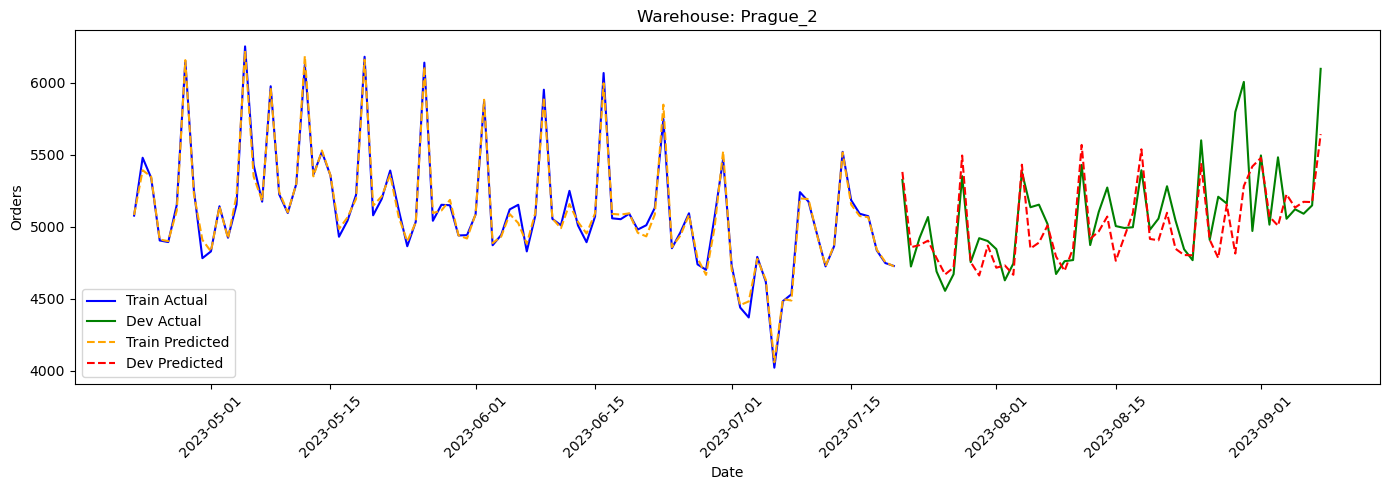

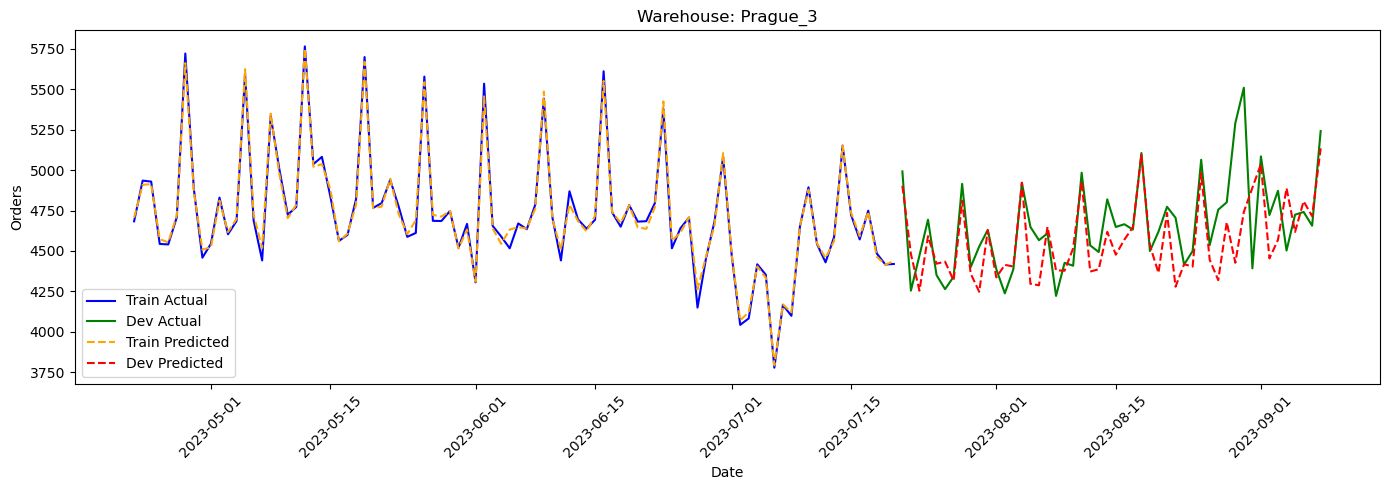

In [35]:
cb = CatBoostRegressor(iterations=3000, learning_rate=0.1, depth=6, verbose = 0)
train_eval_model(X_train, y_train, X_dev, y_dev, cb, orders_scaler)

### 3. LGBM

In [36]:
# lgbm =lgb.LGBMRegressor(n_estimators=500, learning_rate=0.1, num_leaves=31, max_depth=-1)
# train_eval_model(X_train, y_train, X_dev, y_dev, lgbm, orders_scaler)


### 4. Random Forest


In [37]:
# rf = RandomForestRegressor(n_estimators=100, max_depth=None, 
#                              min_samples_split=2, min_samples_leaf=1, 
#                              max_samples=None)
# train_eval_model(X_train, y_train, X_dev, y_dev, rf, orders_scaler)

# Forecasting unseen data!

In [38]:
# Reading the data
test_set = pd.read_csv('Data/test.csv')

In [39]:
# Remove id from test df and save ids to add them to the submission file later
test_ids = test_set['id']
test_set = test_set.drop(['id'], axis=1)

## Preprocessing

In [40]:
# Fill nulls same as training data
test_set['holiday_name'].fillna('None', inplace=True)

In [41]:
# Onehot encoding
test_set = onehot_encode(test_set, columns_to_encode, onehot_encoder, is_test= True)

In [42]:
# Process dates
test_set = preprocess_dates(test_set)

In [43]:
# Scale data
test_set = scale(test_set, date_features, date_scaler, is_test= True)


In [44]:
# Make sure columns order match trained on
test_set = test_set[sorted(test_set.columns)]

In [45]:
# Display the shape of the test set before adding initial windows
print(f"Test set shape: {test_set.shape}")

Test set shape: (397, 52)


In [46]:
# Get the last N days from each warehouse in the dev set (the test set dates follow it closely after)
last_n_days_dev = dev_set_unrolled.groupby('warehouse').tail(window_size)

# Append the last N days to the test_set
test_set = pd.concat([last_n_days_dev, test_set]).reset_index(drop=True)

# Grouping by warehouse to make sure everything is in order
grouped_df = test_set.groupby('warehouse')

# Concatenate the groups back together
test_set = pd.concat([group for _, group in grouped_df])

# Display the shape of the test set after adding 14 * 7 samples
print(f"Test set shape: {test_set.shape}")


Test set shape: (495, 53)


In [47]:
# This function could be a bit more optimized but it requires some more thinking put into it
def recursive_forecast(df, target_column, model, window_size=14, lag_columns=[], drop_columns=['date', 'holiday_name', 'warehouse', 'orders']):
    rolling_dfs = []
    
    # Group by warehouse to handle each group separately
    for _, warehouse_df in df.groupby('warehouse'):
        warehouse_df = warehouse_df.reset_index(drop=True)
        
        # Ensure we start with at least window_size (14) days of data
        initial_window = window_size
        
        # Iterate through each day, starting from the 15th day
        for idx in range(initial_window, len(warehouse_df)):
            # Add lag features from the previous 14 days (sample by sample)
            for col in lag_columns:
                for i in range(1, window_size + 1):
                    warehouse_df.at[idx, f'{col}_lag_{i}'] = warehouse_df.at[idx - i, col]
            
            # Prepare the features by dropping unnecessary columns before prediction
            current_sample = warehouse_df.loc[idx, :].drop(drop_columns).values.reshape(1, -1)

            # Predict the target variable (orders)
            prediction = model.predict(current_sample)[0]
    
            # Update the orders column with the predicted value
            warehouse_df.at[idx, target_column] = prediction
            
        # Append the processed DataFrame for this warehouse but remove the first window 
        warehouse_df = warehouse_df.iloc[window_size:]
        rolling_dfs.append(warehouse_df)
    
    # Concatenate all the processed DataFrames for all warehouses
    final_df = pd.concat(rolling_dfs, axis=0).reset_index(drop=True)
    final_df.dropna(inplace=True)
    
    return final_df

In [48]:
import warnings
warnings.filterwarnings("ignore", message="DataFrame is highly fragmented")

# Predict the orders for those days
test_set_with_predictions = recursive_forecast(test_set, target_column='orders', model=xgb, window_size=window_size, lag_columns=features_to_roll)

In [49]:
# Display the shape of the test set after predictions (initial window should be removed)
print(f"Test set shape: {test_set_with_predictions.shape}")

Test set shape: (397, 123)


# Plotting model forecast on train-dev-test

In [50]:
# Plots a graph of the model's predictions on train and dev set across timestamps, grouped by warehouse
def plot_model_forecast_with_test(X_train, X_dev, y_train, y_train_pred, y_dev, y_dev_pred, train_date, dev_date, train_warehouse, dev_warehouse, test_set_with_predictions):
    # Create copies of X_train and X_dev to avoid modifying the original data
    X_train_copy = X_train.copy()
    X_dev_copy = X_dev.copy()

    # Add the dates and warehouses back to plot them (they were removed earlier in preprocessing)
    X_train_copy['date'] = train_date
    X_train_copy['warehouse'] = train_warehouse
    X_dev_copy['date'] = dev_date
    X_dev_copy['warehouse'] = dev_warehouse

    # Create dataframes for train and dev with actual and predicted orders
    X_train_copy['actual_orders'] = y_train
    X_train_copy['predicted_orders'] = y_train_pred

    X_dev_copy['actual_orders'] = y_dev
    X_dev_copy['predicted_orders'] = y_dev_pred
            
    # Group train and dev data by warehouse
    train_by_warehouse = {warehouse: warehouse_df for warehouse, warehouse_df in X_train_copy.groupby('warehouse')}
    dev_by_warehouse = {warehouse: warehouse_df for warehouse, warehouse_df in X_dev_copy.groupby('warehouse')}
    test_by_warehouse = {warehouse: warehouse_df for warehouse, warehouse_df in test_set_with_predictions.groupby('warehouse')}
    
    # Plot predictions and actuals for each warehouse individually and plot unseen tests too
    for warehouse in train_by_warehouse.keys():
        plt.figure(figsize=(14, 5))
        plt.title(f"Warehouse: {warehouse}")
        
        # Get train, dev and test data for current warehouse
        train_warehouse_data = train_by_warehouse[warehouse].tail(120)
        dev_warehouse_data = dev_by_warehouse.get(warehouse, pd.DataFrame())  # Get dev data for the warehouse or empty if none
        test_warehouse_data = test_by_warehouse.get(warehouse, pd.DataFrame())  # Get dev data for the warehouse or empty if none

        # Plot actual orders for train and dev
        plt.plot(train_warehouse_data['date'], train_warehouse_data['actual_orders'], label='Train Actual', color='blue', linestyle='-')
        plt.plot(dev_warehouse_data['date'], dev_warehouse_data['actual_orders'], label='Dev Actual', color='green', linestyle='-')

        # Plot predicted orders for train and dev and test
        plt.plot(train_warehouse_data['date'], train_warehouse_data['predicted_orders'], label='Train Predicted', color='orange', linestyle='--')
        plt.plot(dev_warehouse_data['date'], dev_warehouse_data['predicted_orders'], label='Dev Predicted', color='red', linestyle='--')
        plt.plot(test_warehouse_data['date'], test_warehouse_data['orders'], label='Test Predicted', color='yellow', linestyle='--')

        plt.xlabel('Date')
        plt.ylabel('Orders')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout() 
        plt.show()


In [51]:
# Specify which model to use
model = xgb

# Make predictions on the training set
y_train_pred = model.predict(X_train)

# Make predictions on the validation set
y_dev_pred = model.predict(X_dev)

# Reshape predictions to 2D for inverse scaling (StandardScaler expects 2D arrays)
y_train_pred = y_train_pred.reshape(-1, 1)
y_dev_pred = y_dev_pred.reshape(-1, 1)

# Making some copies to manipulate
y_train_copy = y_train.copy()
y_dev_copy = y_dev.copy()

y_train_copy = np.array(y_train_copy).reshape(-1, 1)
y_dev_copy= np.array(y_dev_copy).reshape(-1, 1)

y_test = np.array(test_set_with_predictions['orders']).reshape(-1, 1)

# Inverse scale the target variable predictions back to the original scale
y_train_pred = orders_scaler.inverse_transform(y_train_pred).reshape(-1)
y_dev_pred = orders_scaler.inverse_transform(y_dev_pred).reshape(-1)
y_train_copy = orders_scaler.inverse_transform(y_train_copy).reshape(-1)
y_dev_copy = orders_scaler.inverse_transform(y_dev_copy).reshape(-1)
y_test = orders_scaler.inverse_transform(y_test).reshape(-1)

#Put the scaled orders back into the df
test_set_with_predictions['orders'] = y_test


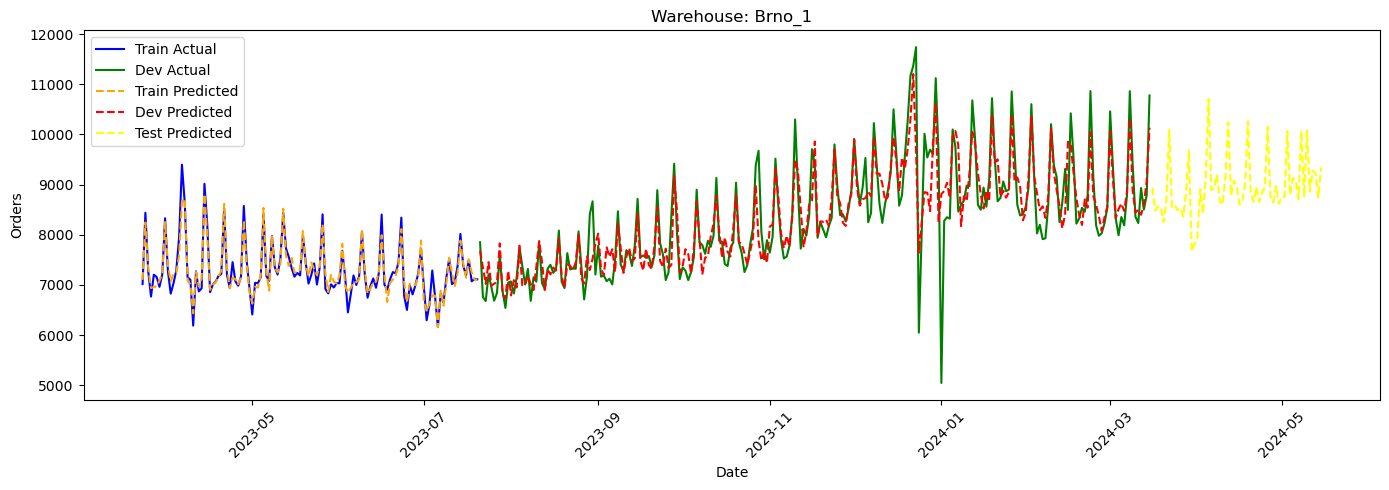

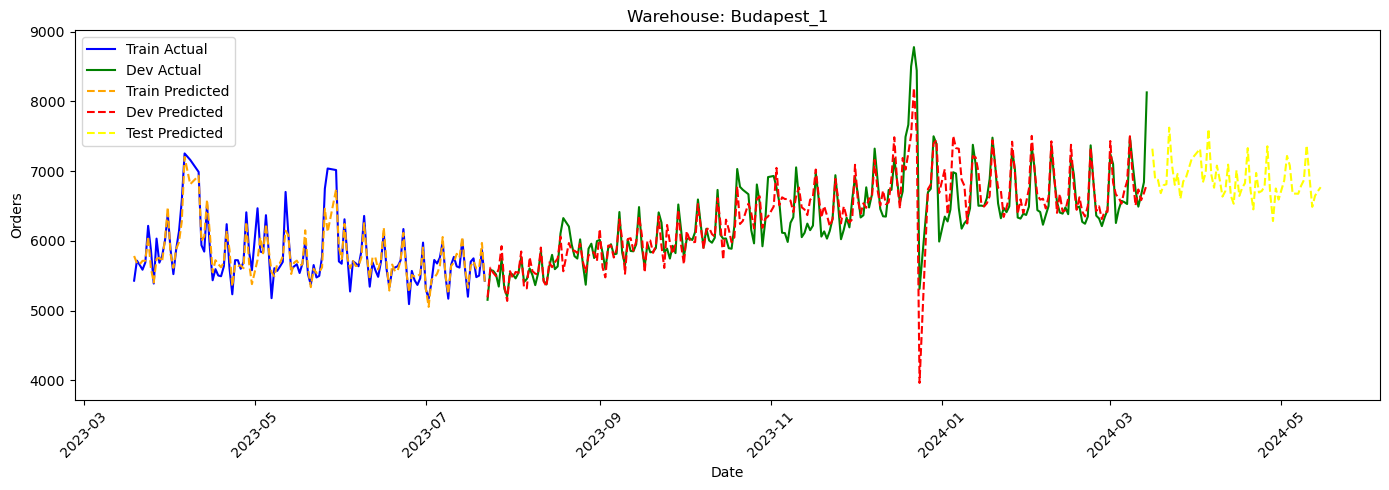

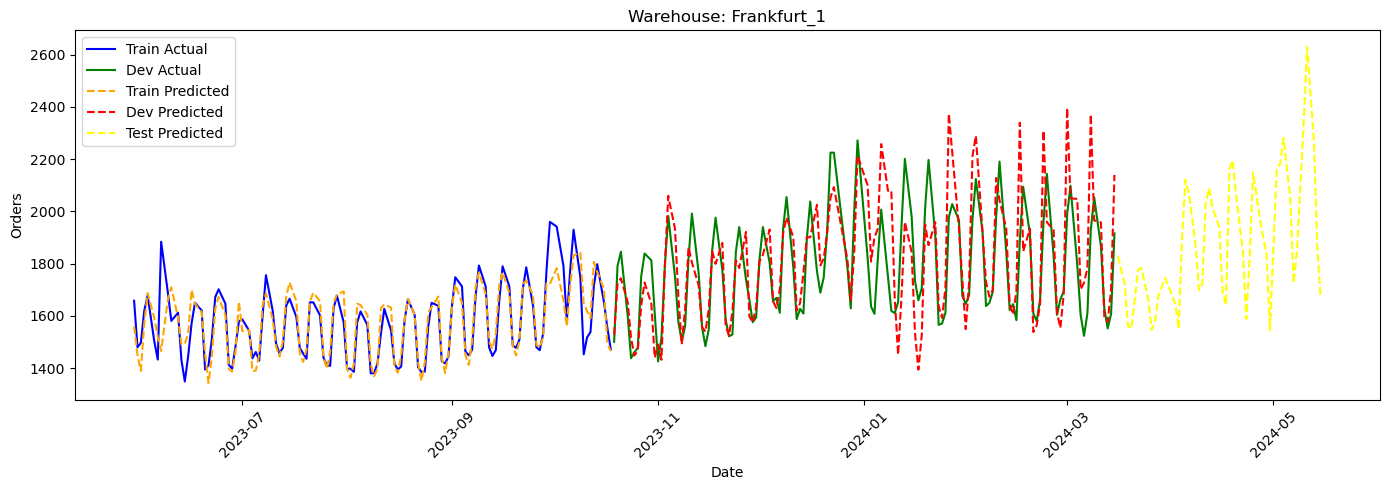

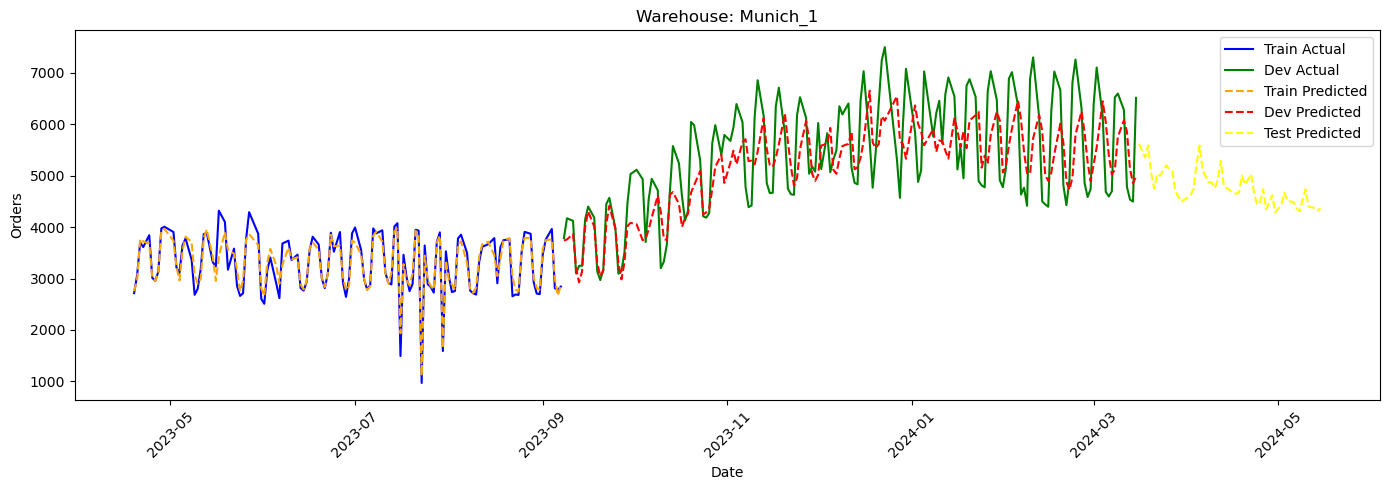

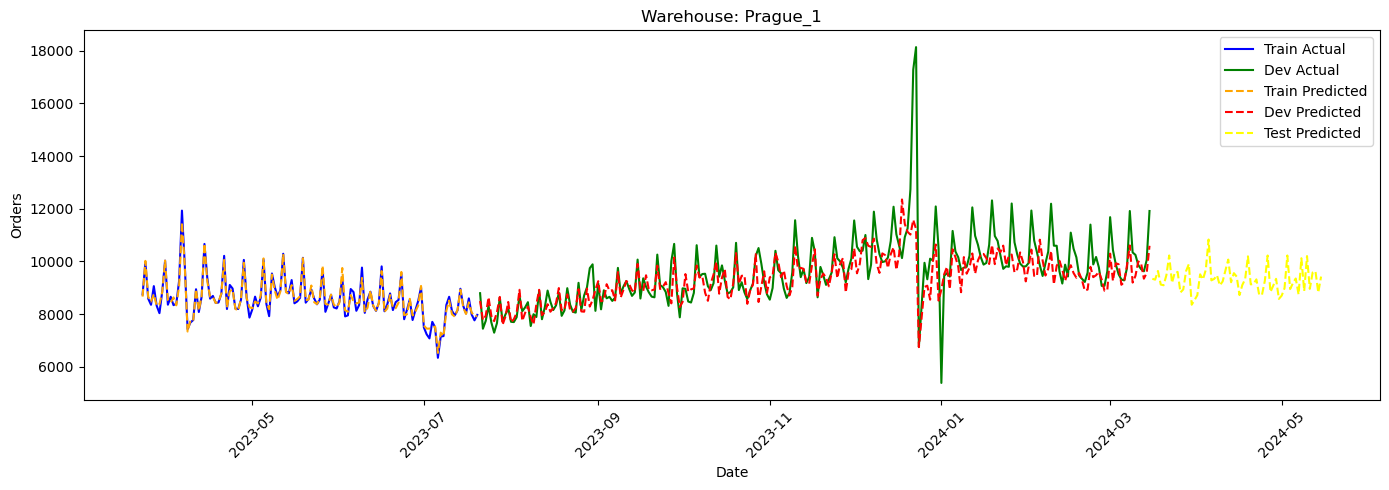

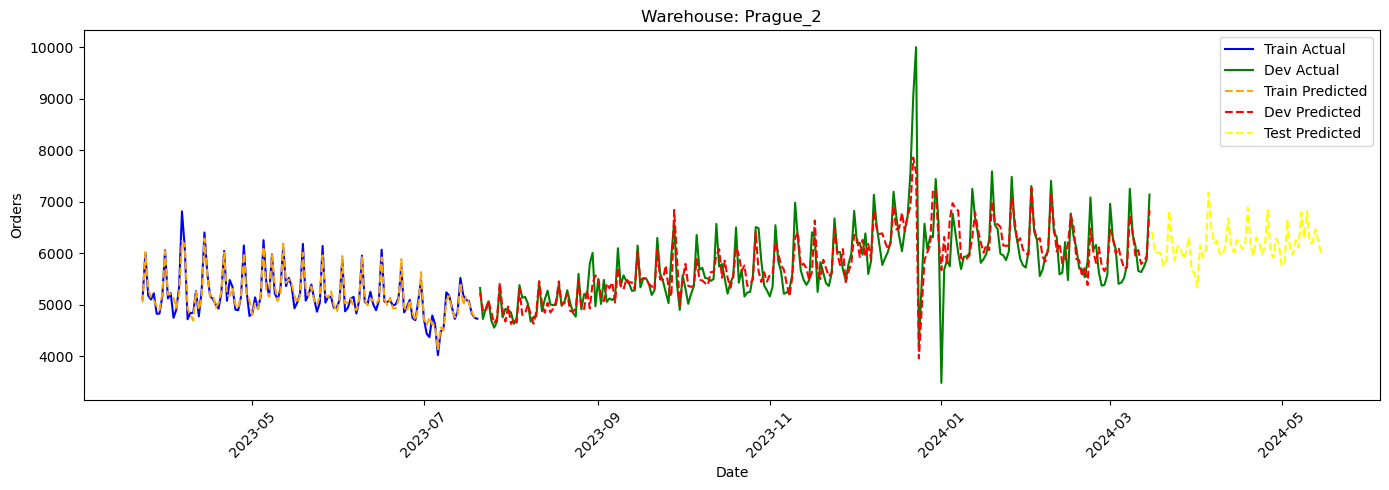

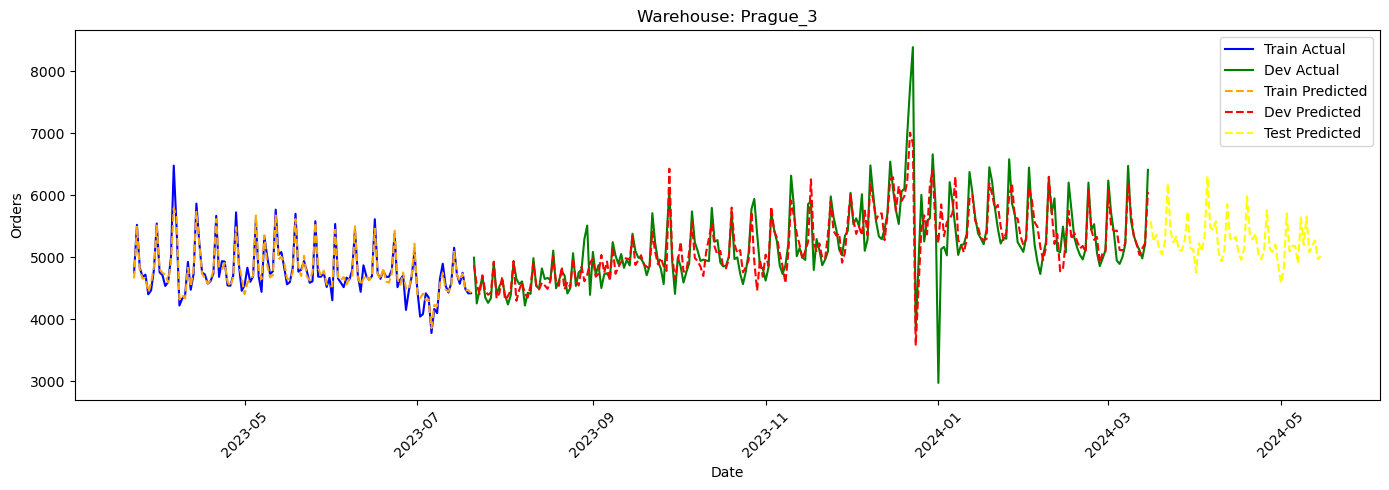

In [52]:
# Plot
plot_model_forecast_with_test(X_train, X_dev, y_train_copy, y_train_pred, y_dev_copy, y_dev_pred, train_date, dev_date, train_warehouse, dev_warehouse, test_set_with_predictions)


In [53]:
# Reorder the test set that has predictions by warehouse orders expected in submission file
ordered_warehouses = ['Prague_1', 'Brno_1', 'Prague_2', 'Prague_3', 'Munich_1', 'Frankfurt_1', 'Budapest_1']

# Ensure the test set is grouped and concatenated based on the specified order
test_set_with_predictions_ordered = pd.concat([test_set_with_predictions[test_set_with_predictions['warehouse'] == warehouse] 
                      for warehouse in ordered_warehouses]).reset_index(drop=True)

In [54]:
# Create and save submission DataFrame
submission_df = pd.DataFrame({
    'id': test_ids,
    'orders': test_set_with_predictions_ordered['orders']
})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False, encoding='utf-8-sig')

print("Submission file saved as 'submission.csv'")


# This approach (using sequences of past days) results in a MAPE of 0.07 on kaggle, 
# however using a classical regression aproach without history data yields pretty good perforamnce even reaching 0.03 mape
# but it is not logical to do that as the data is a time series and should be treated as such

Submission file saved as 'submission.csv'
